In [89]:
# import
import sys
sys.path.append('/Users/ree/Documents/Research/RegimeSurrogate/code/CG')
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
from numba import jit
import math
import skfuzzy as fuzz
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa import stattools 
from scipy.stats import gaussian_kde
import joblib
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
# from sklearn.metrics import silhouette_score
from scipy.integrate import odeint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# from FKNN import FuzzyKNN, calculate_distances
from sklearn.metrics import silhouette_score
from scipy import io
from scipy.linalg import det
from selecandies import physi_constrain, selc_candifunc, indicate, find_index, find_index_flatten 
from collections import defaultdict
import os
from collections import Counter
from scipy.io import loadmat


# fix the random seed
np.random.seed(2022)

In [47]:
# Parameters
dt = 0.002
T = 12000
N = int(T / dt)
noise = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/noise.mat')['noise']
xx = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/xx.mat')['xx'][0]
p = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/p.mat')['p'][0]
m = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/m.mat')['m'][0][0]
lambda_val = 2/60
n = len(xx)
Phi = np.zeros(n)
sgm = np.zeros(n)
for i in range(1, n): 
    Phi[i] = np.trapz((xx[:i+1] - m) * p[:i+1], xx[:i+1])
    sgm[i] = np.real(np.sqrt(2 / p[i] * (-lambda_val * Phi[i])))  # replace lambda_val with your lambda variable
I = np.zeros(N)
for i in range(1, N):
    temp = round(I[i-1] * 10)
    temp = max(0, min(temp, n - 1))
    sgm_x = sgm[temp]
    I[i] = I[i-1] + (-lambda_val * (I[i-1] - m) * dt) + sgm_x * noise[5, i-1] * np.sqrt(dt)


In [56]:
# ENSO model
@jit(nopython=True)
def reference_model(dt, N, noise, p, xx, m, n, Phi, sgm, I):
    factor = 0.6
    
    c = 1
    gamma = 0.75 * factor
    r = 0.25 * factor
    alpha_2 = 0.125 * factor
    alpha_1 = alpha_2 / 2
    b_0 = 2.5
    mu = 0.5

    u_3R = np.zeros(N)
    h_W_3R = np.zeros(N)
    T_C_3R = np.zeros(N)
    T_E_3R = np.zeros(N)
    s1 = np.zeros(N)
    s2 = np.zeros(N)
    s3 = np.zeros(N)
    tau = np.zeros(N)
    d_tau = 2
    Cu = 0.03 * factor
    currentState = 'A'

    sigma_A = 0.1
    sigma_B = 2.0
    random_state_changes = np.random.rand(N-1) > 0.9
    current_state_is_A = currentState == 'A'
    states_is_A = [current_state_is_A]
    
    # Since the state changes are stochastic, we still need a loop to update them
    for i in range(1, N):
        if current_state_is_A and random_state_changes[i-1]:
            current_state_is_A = False
        elif not current_state_is_A and random_state_changes[i-1]:
            current_state_is_A = True
        states_is_A.append(current_state_is_A)
        
        sigma = sigma_A if current_state_is_A else sigma_B
#         sigma = sigma_A
        
        c1 = 26 * (T_C_3R[i-1] + 0.1)**2 + 0.95
        c1 = c1 * (1 + 0.4 * math.sin((i+1)*dt*2*math.pi/6))
        c1 = c1 * factor
        
        sigma_tau = 0.9 * (math.tanh(4.5 * T_C_3R[i-1]) + 1) * (1 + 0.25 * math.cos((i+1)*dt*2*math.pi/6))
        beta_E = (1.0 + (1 - I[i-1]/5)) / 10 * 1.6 * np.sqrt(factor)
        beta_u = -0.2 * beta_E
        beta_h = -0.4 * beta_E
        beta_C = 0.8 * beta_E
        
        c2 = 1.5 * factor * (1 + 0.4 * math.sin((i+1)*dt*2*math.pi/6 + 2*math.pi/6) + 0.2 * math.sin(2*(i+1)*dt*2*math.pi/6 + 2*math.pi/6))

        u_3R[i] = u_3R[i-1] + (-r * u_3R[i-1] - alpha_1 * b_0 * mu / 2 * (T_C_3R[i-1] + T_E_3R[i-1])) * dt + 0.04 * np.sqrt(factor) * np.sqrt(dt) * noise[0, i-1] + beta_u * tau[i-1] * dt
        h_W_3R[i] = h_W_3R[i-1] + (-r * h_W_3R[i-1] - alpha_2 * b_0 * mu / 2 * (T_C_3R[i-1] + T_E_3R[i-1])) * dt + 0.02 * np.sqrt(factor) * np.sqrt(dt) * noise[1, i-1] + beta_h * tau[i-1] * dt
        T_C_3R[i] = T_C_3R[i-1] + ((gamma * b_0 * mu / 2 - c1) * T_C_3R[i-1] + gamma * b_0 * mu / 2 * T_E_3R[i-1] + gamma * h_W_3R[i-1] + sigma * u_3R[i-1] + Cu) * dt + beta_C * tau[i-1] * dt + 0.02 * 2 * np.sqrt(factor) * np.sqrt(dt) * noise[2, i-1]
        T_E_3R[i] = T_E_3R[i-1] + (gamma * h_W_3R[i-1] + (gamma * b_0 * mu / 2 + gamma * b_0 * mu - c2) * T_E_3R[i-1] + (gamma * b_0 * mu / 2 - gamma * b_0 * mu) * T_C_3R[i-1]) * dt + beta_E * tau[i-1] * dt + 0.03 * np.sqrt(dt) * np.sqrt(factor) * noise[3, i-1]
        tau[i] = tau[i-1] - d_tau * tau[i-1] * dt + sigma_tau * noise[4, i-1] * np.sqrt(dt)

        s1[i-1] = np.sin(np.pi * (i+1) * dt / 3)
        s2[i-1] = np.sin(np.pi * (i+1) * dt / 3 + 2 * np.pi / 6)
        s3[i-1] = np.sin(2 * np.pi * (i+1) * dt / 3 + 2 * np.pi / 6)

    # Return all the calculated arrays
    return u_3R, h_W_3R, T_C_3R, T_E_3R, tau, I, s1, s2, s3, noise, states_is_A


# Call the model function
refer_run = {}
u_3R, h_W_3R, T_C_3R, T_E_3R, tau, I, s1, s2, s3, noise, states_is_A = reference_model(dt, N, noise, p, xx, m, n, Phi, sgm, I)
refer_run['u'] = u_3R; refer_run['hW'] = h_W_3R; refer_run['TE'] = T_E_3R; refer_run['TC'] = T_C_3R; refer_run['tau'] = tau; refer_run['I'] = I; refer_run['s1'] = s1; refer_run['s2'] = s2; refer_run['s3'] = s3; refer_run['noise'] = noise; refer_run['label'] = states_is_A;
np.save('../data/referrun_enso.npy', refer_run)

In [70]:
# load data
# u = np.load('../data/referrun_enso.npy',allow_pickle=True).item()['u']
# hW = np.load('../data/referrun_enso.npy',allow_pickle=True).item()['hW']
# TE = np.load('../data/referrun_enso.npy',allow_pickle=True).item()['TE']
# TC = np.load('../data/referrun_enso.npy',allow_pickle=True).item()['TC']
# tau = np.load('../data/referrun_enso.npy',allow_pickle=True).item()['tau']
with h5py.File('../data/enso_sigma2state_referrun.hdf5', 'r') as file:
    Tc = file['T_C'][()][:,0]
    Te = file['T_E'][()][:,0]
    hW = file['h_W'][()][:,0]
    u = file['u'][()][:,0]
    tau = file['tau'][()][:,0]
    I = file['I'][()][:,0]

In [74]:
Te.shape

(6000000,)

# 1.Classification

## 1.2.0 True dynamics regimes

In [59]:
Counter(states_is_A)

Counter({True: 3002756, False: 2997244})

## 1.2.4 Ludo's method

In [84]:
# Ludo's method
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

save_res = 10
with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/enso_sigma2state_TcTe_Ludo_standard.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]

ncenterss = np.max(np.array(labels_)+1, axis=1)
ncenterss = ncenterss[:8]
print('number of clusters:', ncenterss)
print('time scales:', tscales)

label = labels_[1]

number of clusters: [10  2  2  2  2  4  4  4]
time scales: [16.45431256  7.61630268  7.12155171  4.92444706  4.18054767  3.12362802
  3.08980978  2.71618722]


# 2. Surrogate Model

## 2.1 True signals

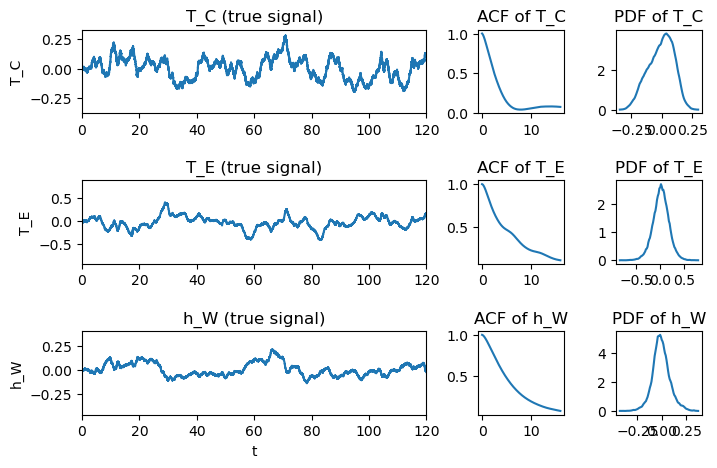

In [96]:
## 2.1 True signals
Lag = 8000

fig = plt.figure(figsize=(8,5))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.3, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = 60000
ax1.plot(np.arange(0, (N) * dt, dt), Tc)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('T_C (true signal)')
ax1.set_ylabel('T_C')

ax2.plot(np.arange(0, (N) * dt, dt), Te)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('T_E (true signal)')
ax2.set_ylabel('T_E')

ax3.plot(np.arange(0, (N) * dt, dt), hW)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('h_W (true signal)')
ax3.set_ylabel('h_W')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(Tc, nlags=Lag-1))
ax4.set_title('ACF of T_C')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(Te, nlags=Lag-1))
ax5.set_title('ACF of T_E')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(hW, nlags=Lag-1))
ax6.set_title('ACF of h_W')

# Subplot for PDF of x_truth
kde = gaussian_kde(Tc)
xx = np.linspace(np.min(Tc), np.max(Tc), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of T_C')

kde = gaussian_kde(Te)
xx = np.linspace(np.min(Te), np.max(Te), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of T_E')

kde = gaussian_kde(hW)
xx = np.linspace(np.min(hW), np.max(hW), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of h_W')
plt.savefig('../figure/truesign_enso.png', dpi=150)
plt.show()

## 2.3 Surrogate Model of the Regimes

In [ ]:
# ***************************************************************************************************************

In [ ]:
# Model Identification - Ludo's - 2 regimes
# load label data
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content
save_res = 10
with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/enso_sigma2state_TcTe_Ludo_standard.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]
label = labels_[1]

# Define candidates and true model structure
candifunc = [['Tc', 'Te', 'hW', 'u', 'tau', 'I'],
             ['Tc', 'Te', 'hW', 'u', 'tau', 'I'],
             ['Tc', 'Te', 'hW', 'u', 'tau', 'I']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [50]:
# check code aligning with matlab
u_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/u_3R.mat')['u_3R'][0]
h_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/h_W_3R.mat')['h_W_3R'][0]
tc_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/T_C_3R.mat')['T_C_3R'][0]
te_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/T_E_3R.mat')['T_E_3R'][0]
tau_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/tau.mat')['tau'][0]
I_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/I.mat')['I'][0]
s1_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/s1.mat')['s1'][0]
s2_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/s2.mat')['s2'][0]
s3_mat = loadmat('/Users/ree/Documents/Research/RegimeSurrogate/code/ENSO/s3.mat')['s3'][0]

In [51]:
(u_mat-u_3R)[-10:]

array([-0.00419442, -0.00420116, -0.00420916, -0.0042153 , -0.00422023,
       -0.00422632, -0.00423301, -0.00423687, -0.00424153, -0.00424545])

In [37]:
(h_mat-h_W_3R)[-10:]

array([-1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17])

In [38]:
(tc_mat-T_C_3R)[-10:]

array([2.77555756e-17, 2.77555756e-17, 2.77555756e-17, 2.77555756e-17,
       2.77555756e-17, 2.77555756e-17, 2.77555756e-17, 2.77555756e-17,
       2.77555756e-17, 2.77555756e-17])

In [39]:
(te_mat-T_E_3R)[-10:]

array([1.38777878e-17, 1.38777878e-17, 1.38777878e-17, 1.38777878e-17,
       1.38777878e-17, 1.38777878e-17, 1.38777878e-17, 1.38777878e-17,
       1.38777878e-17, 1.38777878e-17])

In [40]:
(tau_mat-tau)[-10:]

array([2.77555756e-16, 2.77555756e-16, 2.77555756e-16, 2.77555756e-16,
       2.81025203e-16, 2.84494650e-16, 2.84494650e-16, 2.84494650e-16,
       2.77555756e-16, 2.77555756e-16])

In [34]:
(I_mat-I)[-10:]

array([-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
       -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
       -8.8817842e-16, -8.8817842e-16])

In [41]:
(s1_mat-s1)[-10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
(s2_mat-s2)[-10:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.11022302e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [43]:
(s3_mat-s3)[-10:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11022302e-16,
       0.00000000e+00, 0.00000000e+00])